# Abalone Dataset

In [1]:
# Import packages
from Bias import BIASme, bias_rotate_2D
from Transformations import remove_outliers_lof, trafo_ica
from DensityEstimators import DE_histogram, DE_kde
from IMITATE import IMITATE
from scipy import stats
from sklearn import svm
import pandas as pd
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# class label = sex
def loadData_abalone(dataset_size=4177):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
    dataset = pd.read_csv(url, header=None)
    y = dataset[0].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,6]<0.144 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([0,6], axis=1).to_numpy()
    X = np.append(X, isInB, axis=1)
    
    return X, y

[Text(167.4, 163.07999999999998, 'X[5] <= 0.144\ngini = 0.665\nsamples = 4177\nvalue = [1307, 1342, 1528]'),
 Text(83.7, 54.360000000000014, 'gini = 0.532\nsamples = 1730\nvalue = [265, 1092, 373]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.585\nsamples = 2447\nvalue = [1042, 250, 1155]')]

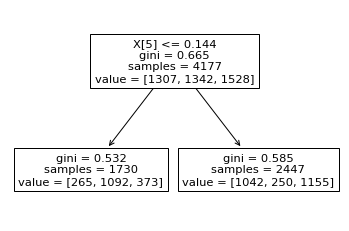

In [19]:
# quick check for the most predictive attribute:
from sklearn import tree
X, y = loadData_abalone()
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X[:,0:len(X[0])-1],y)
tree.plot_tree(clf) 

In [3]:
# remove all mushrooms with rings <= 8
def bias_abalone(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

In [9]:
def run_experiment(num_bins, model, repeat=10):
    DE = lambda b: DE_kde(num_bins=b, kernel='gau')
    data_gen = loadData_abalone
    bias_gen = bias_abalone
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, model=model, DE=DE, trafo=trafo_ica)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = 0
    for bins in num_bins:
        for i in range(repeat):
            bh.reset()
            label_conf = bh.fill_up(num_bins=bins, iterations=10, fill_up_plots=False, point_plots=False, RO=True)
            #print("run", i, ", conf", label_conf)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
    return best_bh

In [12]:
def run_and_eval(runs=10, model=svm.SVC(kernel='linear')):
    acc_init = np.zeros(runs)
    acc_final = np.zeros(runs)
    hist_bins = list(range(10,25,1))
    
    for r in range(runs):
        bh = run_experiment(hist_bins, model=model, repeat=2)
        acc_init[r] = bh.D.acc_unbiased - bh.D.acc_init
        acc_final[r] = bh.D.acc_unbiased - bh.D.accuracyBiased(bh.added_points, bh.added_labels)
        print("run", r, "- acc_i =", acc_init[r], " acc_f =", acc_final[r])

    return acc_init, acc_final

### Linear SVM

In [6]:
res = run_and_eval()

run 0 - acc_i = 0.1403508771929825  acc_f = 0.12599681020733655
run 1 - acc_i = 0.18022328548644334  acc_f = 0.0933014354066985
run 2 - acc_i = 0.14513556618819778  acc_f = 0.08054226475279108
run 3 - acc_i = 0.16826156299840517  acc_f = 0.032695374800638
run 4 - acc_i = 0.16427432216905896  acc_f = 0.09888357256778302
run 5 - acc_i = 0.13955342902711326  acc_f = 0.11084529505582141
run 6 - acc_i = 0.182615629984051  acc_f = 0.08771929824561403
run 7 - acc_i = 0.1251993620414673  acc_f = 0.08532695374800642
run 8 - acc_i = 0.1435406698564593  acc_f = 0.09170653907496013
run 9 - acc_i = 0.11961722488038284  acc_f = 0.0797448165869219


In [7]:
np.average(res, axis=1)

array([0.15087719, 0.08867624])

In [8]:
stats.ttest_ind(res[0], res[1])

Ttest_indResult(statistic=6.015205536381381, pvalue=1.0924579997398722e-05)

### Decision Tree

In [15]:
model = tree.DecisionTreeClassifier
res_tree = run_and_eval(model=model)

run 0 - acc_i = 0.1475279106858054  acc_f = 0.09090909090909088
run 1 - acc_i = 0.15071770334928225  acc_f = 0.12360446570972883
run 2 - acc_i = 0.1355661881977671  acc_f = 0.11164274322169054
run 3 - acc_i = 0.2121212121212121  acc_f = 0.13476874003189793
run 4 - acc_i = 0.14513556618819773  acc_f = 0.11642743221690588
run 5 - acc_i = 0.15151515151515144  acc_f = 0.0071770334928229484
run 6 - acc_i = 0.11562998405103675  acc_f = 0.09011164274322175
run 7 - acc_i = 0.16507177033492826  acc_f = 0.1403508771929825
run 8 - acc_i = 0.14752791068580545  acc_f = 0.08373205741626799
run 9 - acc_i = 0.16586921850079744  acc_f = 0.12679425837320574


In [16]:
np.average(res_tree, axis=1)

array([0.15366826, 0.10255183])

In [21]:
stats.ttest_ind(res_tree[0], res_tree[1])

Ttest_indResult(statistic=3.504686286647387, pvalue=0.0025302605021944773)

### SVM with RBF kernel

In [18]:
model = svm.SVC(kernel='rbf')
res_rbf = run_and_eval(model=model)

run 0 - acc_i = 0.13237639553429031  acc_f = 0.08532695374800642
run 1 - acc_i = 0.12759170653907492  acc_f = 0.05582137161084527
run 2 - acc_i = 0.13636363636363635  acc_f = 0.07496012759170656
run 3 - acc_i = 0.12280701754385964  acc_f = 0.10047846889952156
run 4 - acc_i = 0.15629984051036688  acc_f = 0.10526315789473689
run 5 - acc_i = 0.1770334928229665  acc_f = 0.1515151515151515
run 6 - acc_i = 0.15629984051036683  acc_f = 0.14752791068580545
run 7 - acc_i = 0.17384370015948963  acc_f = 0.07017543859649122
run 8 - acc_i = 0.14832535885167464  acc_f = 0.09489633173843698
run 9 - acc_i = 0.18022328548644334  acc_f = 0.18341307814992025


In [19]:
np.average(res_rbf, axis=1)

array([0.15111643, 0.1069378 ])

In [20]:
stats.ttest_ind(res_rbf[0], res_rbf[1])

Ttest_indResult(statistic=3.028865363039521, pvalue=0.0072174160700024985)